# NYPD Data

## Imports

In [1]:
# data import
import pickle

# data manipulation
import numpy as np
import pandas as pd
from datetime import datetime

# plotting
import matplotlib.pyplot as plt

#gaussian filter
from scipy.ndimage import gaussian_filter

## Data Import

In [2]:
pickle_path = ('../raw_data/clean.pickle')
with open(pickle_path, 'rb') as f:
    df = pickle.load(f)

## Sample

### Select Sample

In [3]:
inf = df['period'] > datetime(2012, 1, 1, 0, 0, 0)
sup = df['period'] < datetime(2013, 1, 1, 0, 0, 0)
sample = df[ inf & sup ]

In [4]:
sample = sample[sample['precinct_number']==75]

In [5]:
sample['longitude'].min(), sample['longitude'].max(), sample['latitude'].min(), sample['latitude'].max() 

(-73.904645897, -73.855902525, 40.607512254, 40.691192349)

### Add Week Column

In [6]:
sample['week'] = sample['period'].apply(lambda x: int(x.strftime('%V')))

### Add 6H Column

In [74]:
def round_six_hours(period):
    
    if period.hour < 6:
        period = period.replace(hour = 0)
        
    elif period.hour < 12 :
        period = period.replace(hour = 6)
        
    elif period.hour < 18 :
        period = period.replace(hour = 12)
        
    else:
        period = period.replace(hour = 18)
        
    return period

sample['six_hour_date'] = sample['period'].apply(lambda x: round_six_hours(x))

### Explore Sample

In [75]:
sample.head()

,precinct_number,offense_type,crime_completed,offense_level,premise_desc,premise,jurisdiction,park_name,suspect_age,suspect_race,...,longitude,metro,victim_age,victim_race,victim_sex,period,borough,patrol_borough,week,six_hour_date
99,75,ASSAULT 3 & RELATED OFFENSES,COMPLETED,MISDEMEANOR,INSIDE,RESIDENCE - APT. HOUSE,N.Y. POLICE DEPT,NOT PARK,UNKNOWN,UNKNOWN,...,-73.866463,NOT SUBWAY,45-64,WHITE HISPANIC,F,2012-08-31 12:00:00,BROOKLYN,PATROL BORO BKLYN NORTH,35,2012-08-31 12:00:00
390,75,FELONY ASSAULT,COMPLETED,FELONY,FRONT OF,STREET,N.Y. POLICE DEPT,NOT PARK,UNKNOWN,BLACK,...,-73.889869,NOT SUBWAY,45-64,BLACK,M,2012-09-01 23:00:00,BROOKLYN,PATROL BORO BKLYN NORTH,35,2012-09-01 18:00:00
875,75,OFF. AGNST PUB ORD SENSBLTY &,COMPLETED,MISDEMEANOR,UNKNOWN,STREET,N.Y. POLICE DEPT,NOT PARK,45-64,BLACK,...,-73.895534,NOT SUBWAY,25-44,BLACK,F,2012-01-03 08:00:00,BROOKLYN,PATROL BORO BKLYN NORTH,1,2012-01-03 06:00:00
964,75,ADMINISTRATIVE CODE,COMPLETED,VIOLATION,UNKNOWN,TRANSIT - NYC SUBWAY,N.Y. TRANSIT POLICE,NOT PARK,UNKNOWN,UNKNOWN,...,-73.865464,GRANT AVENUE,UNKNOWN,UNKNOWN,E,2012-07-26 13:00:00,BROOKLYN,PATROL BORO BKLYN NORTH,30,2012-07-26 12:00:00
1026,75,ASSAULT 3 & RELATED OFFENSES,COMPLETED,MISDEMEANOR,FRONT OF,RESIDENCE-HOUSE,N.Y. POLICE DEPT,NOT PARK,UNKNOWN,UNKNOWN,...,-73.890103,NOT SUBWAY,25-44,BLACK,M,2012-02-27 17:00:00,BROOKLYN,PATROL BORO BKLYN NORTH,9,2012-02-27 12:00:00


In [8]:
del df

In [9]:
sample.shape

(17143, 21)

## Matrix

### Converting Meters to Coordinates

In [10]:
def from_meters_to_coords(lat_meters, lon_meters):
    """
    gives the latitude and longitude step to use for the grid buckets
    lat_meters, lon_meters = lat/lon step
    """
    #Position, decimal degrees
    lat = 40
    lon = -73

    #Earth’s radius, sphere
    R=6378137

    #offsets in meters
    dn = lat_meters
    de = lon_meters

    #Coordinate offsets in radians
    dLat = dn/R
    dLon = de/(R*np.cos(np.pi*lat/180))

    #OffsetPosition, decimal degrees
    latO = dLat * 180/np.pi
    lonO = dLon * 180/np.pi 

    return latO, lonO

### Weekly

#### Computation

In [87]:
def from_coord_to_matrix(df, lat_meters, lon_meters):
    """
    outputs the 3D matrix of all coordinates for a given bucket height and width in meters
    """
    df = df.copy()
    #add 'time_index' column to df
    ind = {time: index for index, time in enumerate(np.sort(df['week'].unique()))}
    df['time_index'] = df['week'].map(ind)
    
    #initiate matrix
    #40.49611539518921, 40.91553277600008, -74.25559136315213,-73.70000906387347) : NYC boundaries
    #([40.56952999448672, 40.73912795313436],[-74.04189660705046, -73.83355923946421]) : brooklyn boundaries
    #[40.6218192717505, 40.6951504231971],[-73.90404639808888, -73.83559344190869]) :precinct 75 boundaries
    
    # Where do you start
    grid_offset = np.array([-40.691192349, -73.904645897, 0])
    #from meters to lat/lon step
    lat_spacing, lon_spacing = from_meters_to_coords(lat_meters, lon_meters )
    grid_spacing = np.array([lat_spacing , lon_spacing,1]) # What's the space you consider (euclidian here)
     
    
    #get points coordinates
    coords = np.array([( -lat, lon,t_ind) for lat, lon,t_ind \
                   in zip(df['latitude'],df['longitude'],df['time_index'])])
    
    
    # Convert point to index
    indexes = np.round((coords - grid_offset)/grid_spacing).astype('int')
    X = indexes[:,0]
    Y = indexes[:,1]
    Z = indexes[:,2]
    
    #virgin matrix
    a = np.zeros((X.max()+1, Y.max()+1, Z.max()+1))
   
    
    a[X, Y, Z]=1
    
    return a, a.shape[1], a.shape[2]

In [88]:
img, lat_size, lon_size = from_coord_to_matrix(sample, 10, 25)

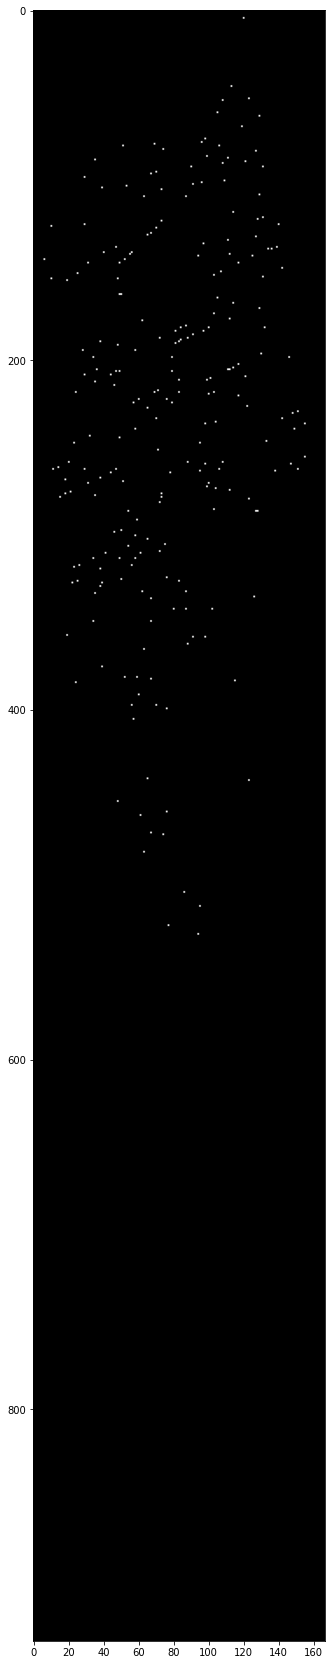

In [89]:
plt.figure(figsize = (30, 30))

plt.imshow(img[:,:,8], cmap='gray');

#### Withougt Gaussian Filter: img.show()

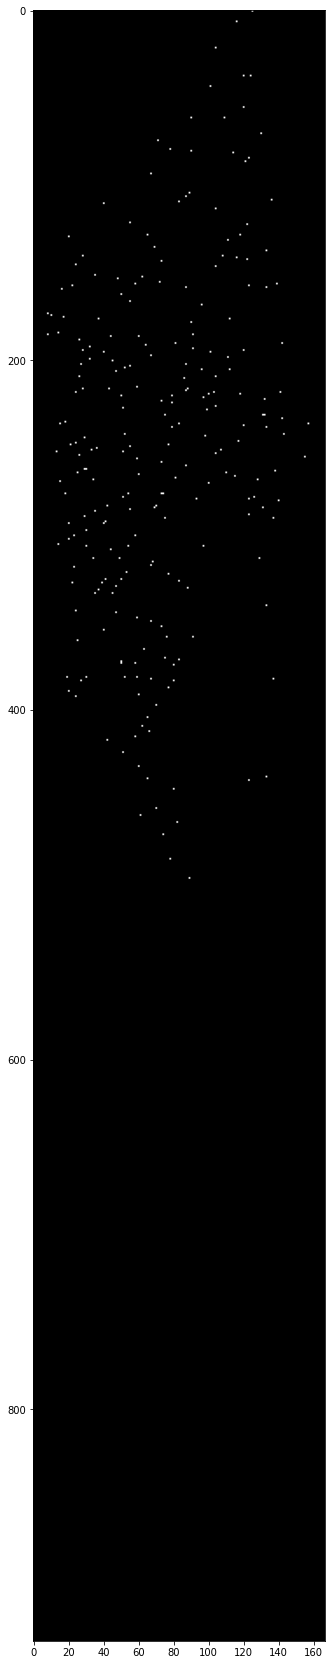

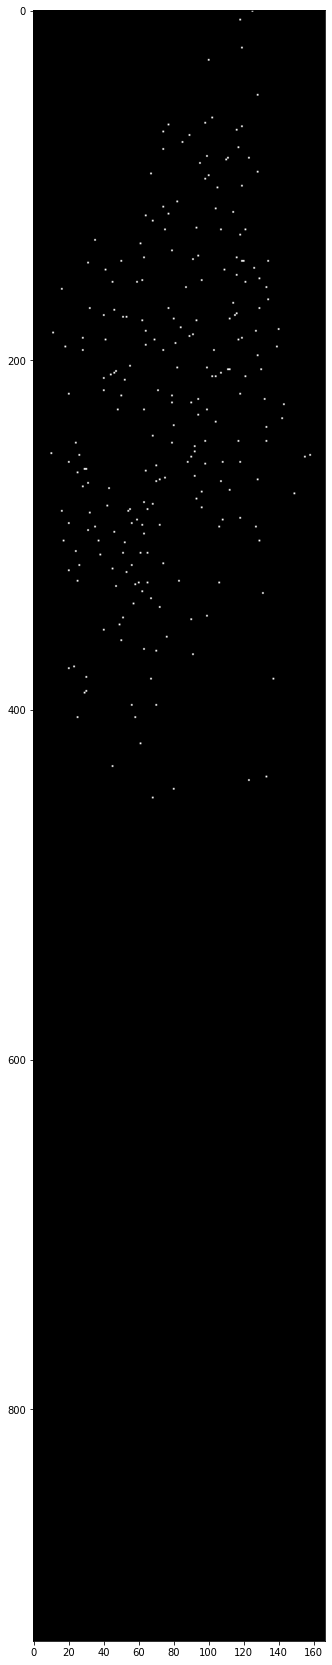

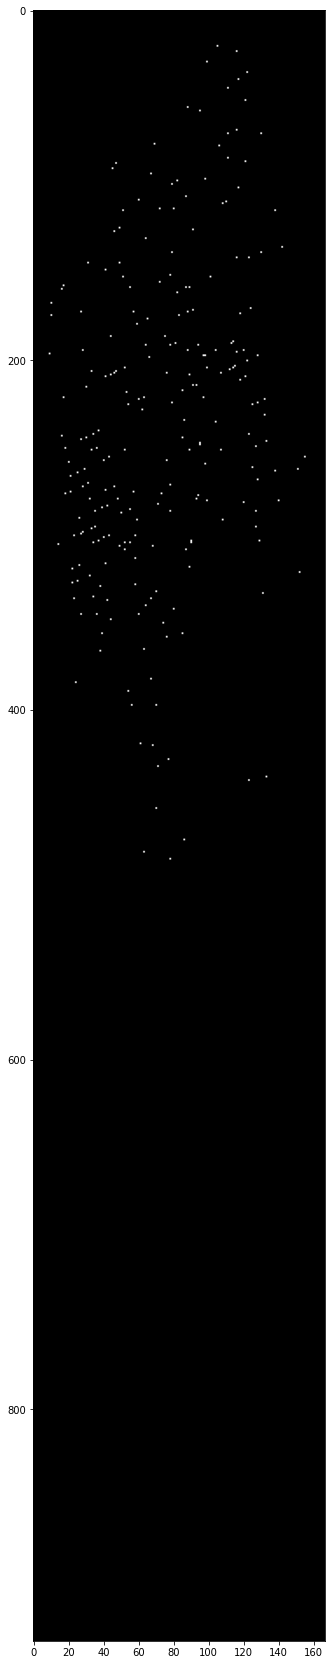

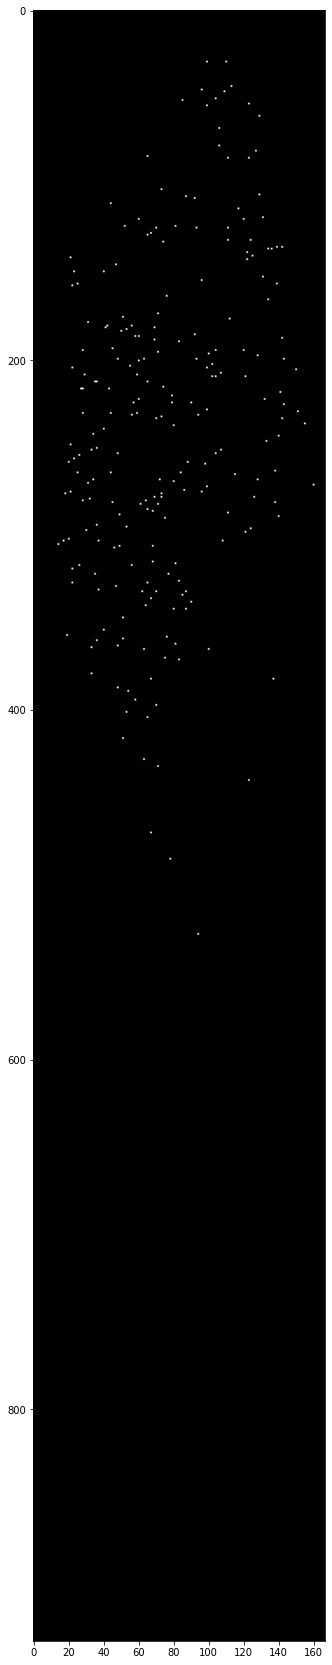

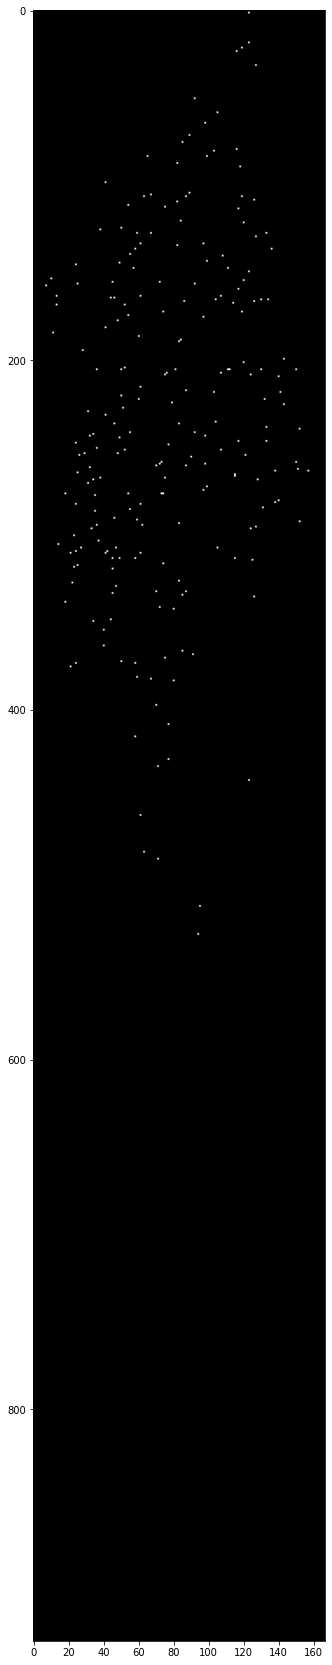

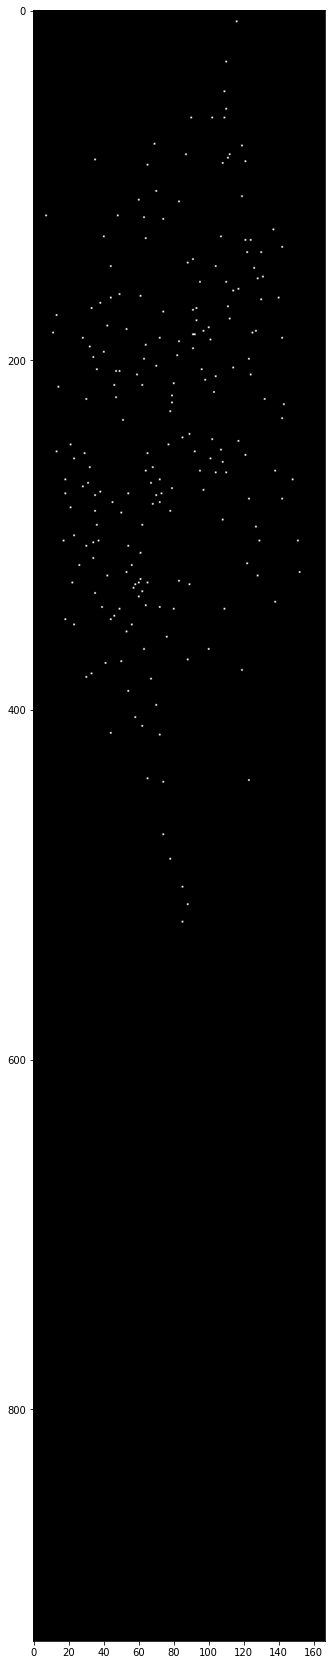

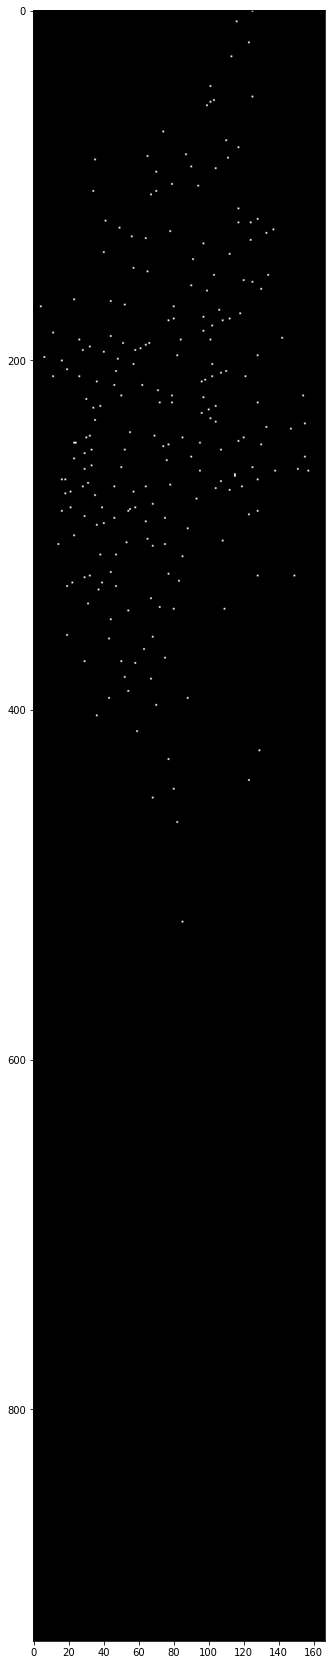

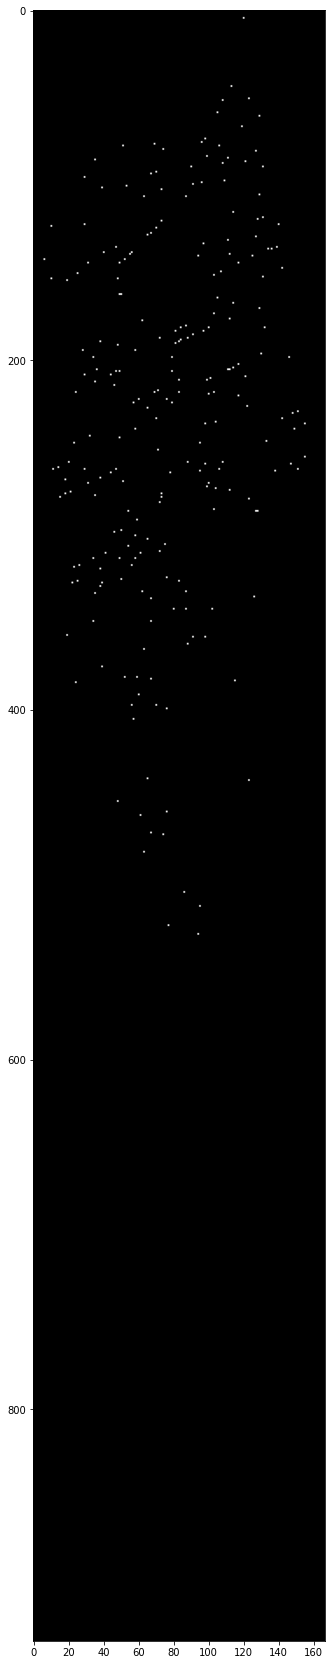

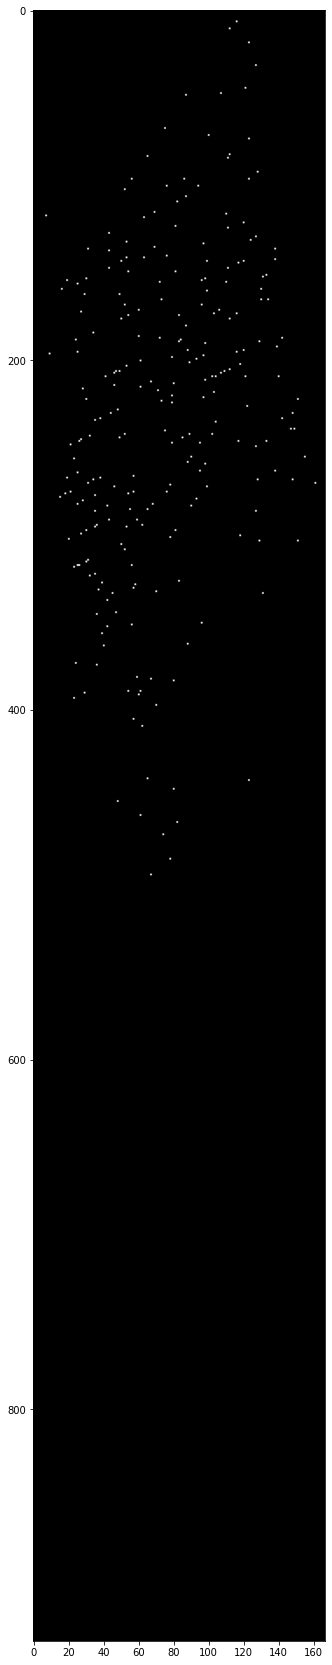

In [90]:
# W/O Gaussian Filter

max_lum = img.max()

for i in range(9):
    plt.figure(figsize = (30, 30))
    plt.imshow(img[:, :, i + 1], cmap = 'gray', vmin = 0, vmax = max_lum)
    plt.show()

#### With Gaussian Filter

**Gaussian Filter**

- **sigma** = represents st. dv. for each axis of img (time, long, lat)

In [95]:
img3D_conv = gaussian_filter(img, sigma=(1, 1, 3))

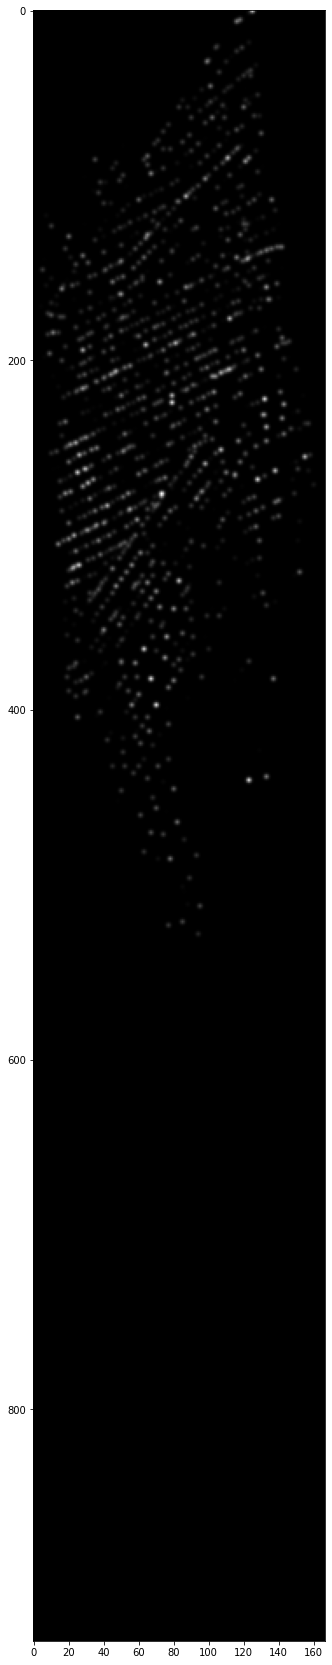

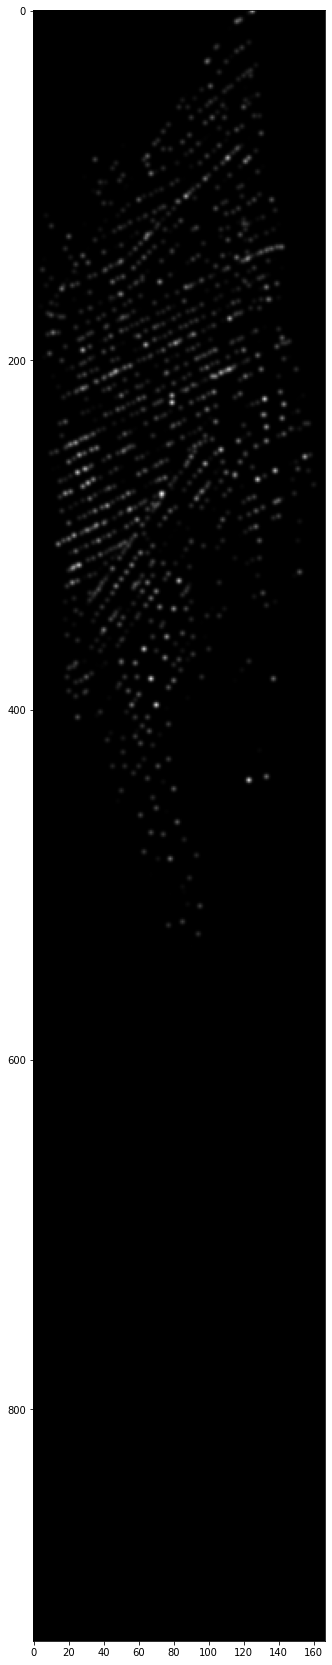

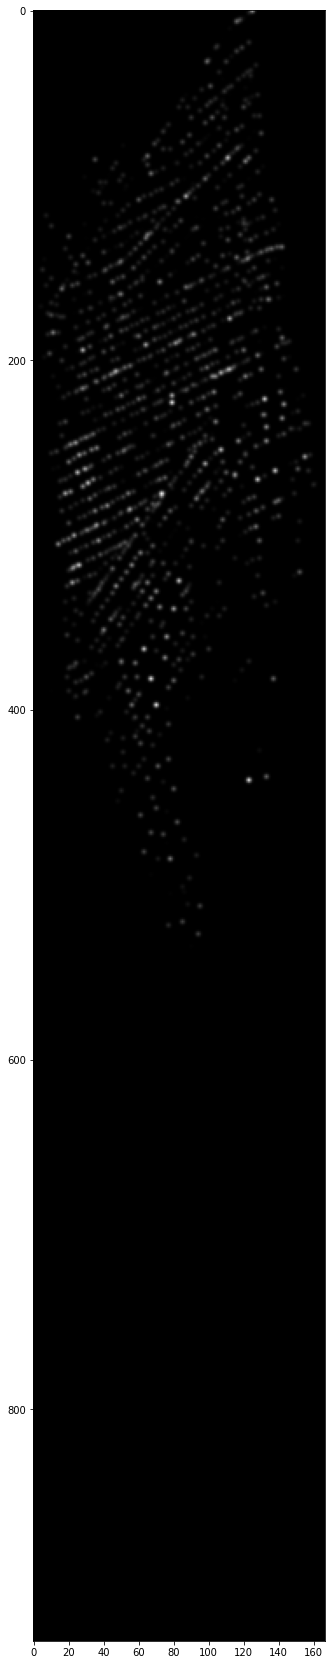

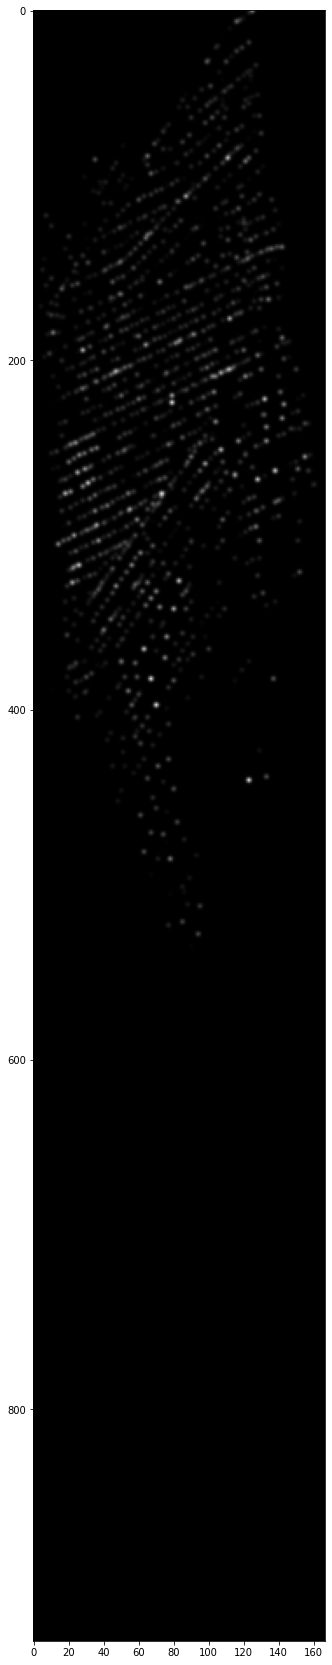

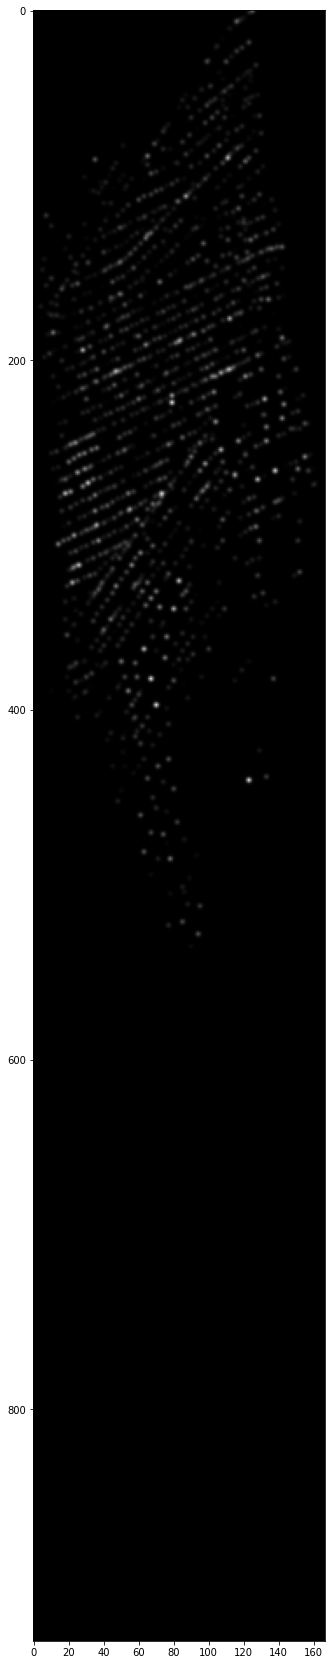

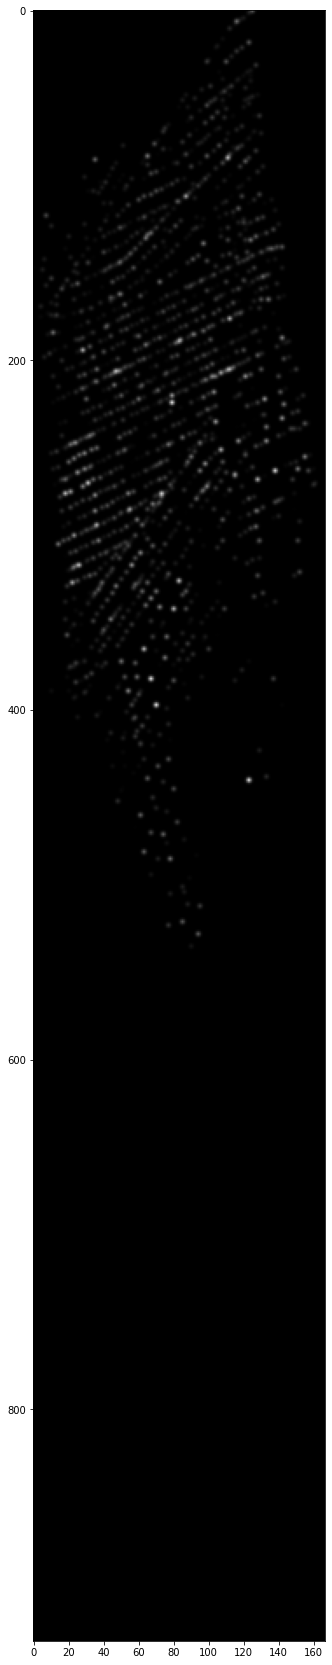

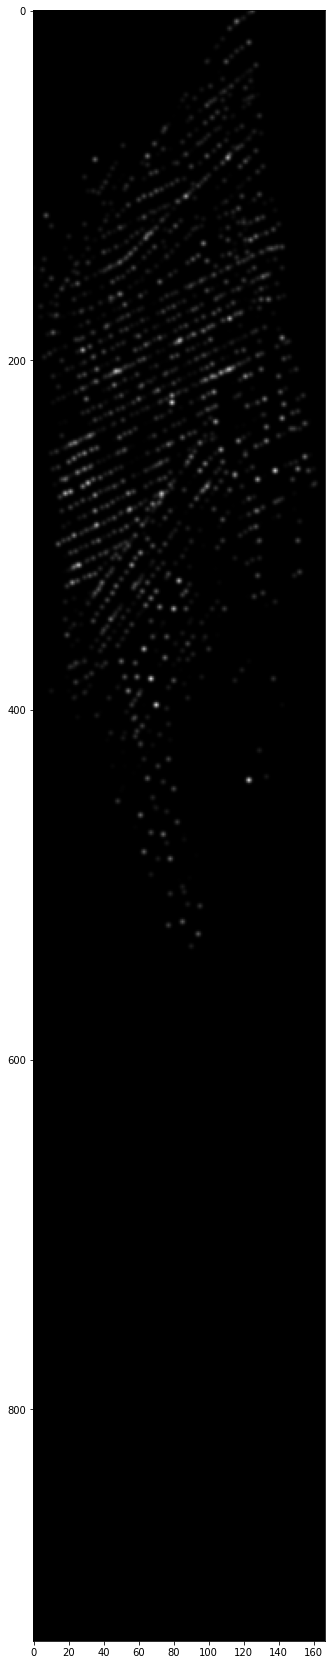

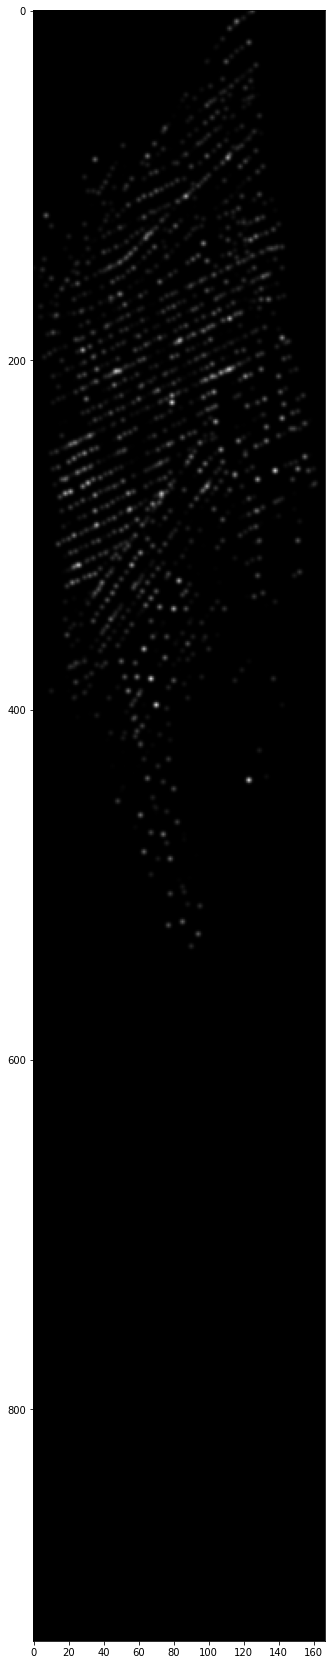

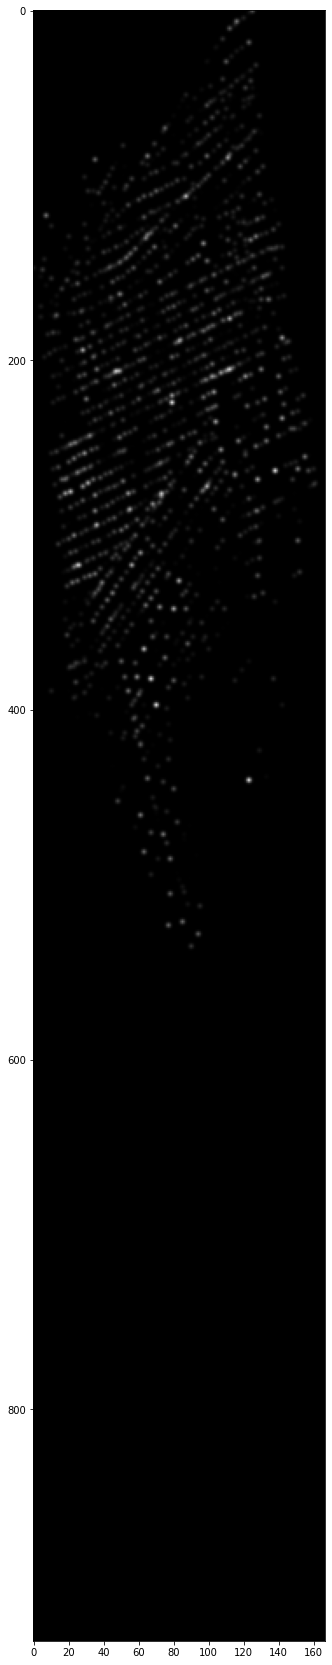

In [96]:
max_lum = img3D_conv.max()

for i in range(9):
    plt.figure(figsize=(30, 30))
    plt.imshow(img3D_conv[:, :, i + 1], cmap = 'gray', vmin = 0, vmax = max_lum)
    plt.show()

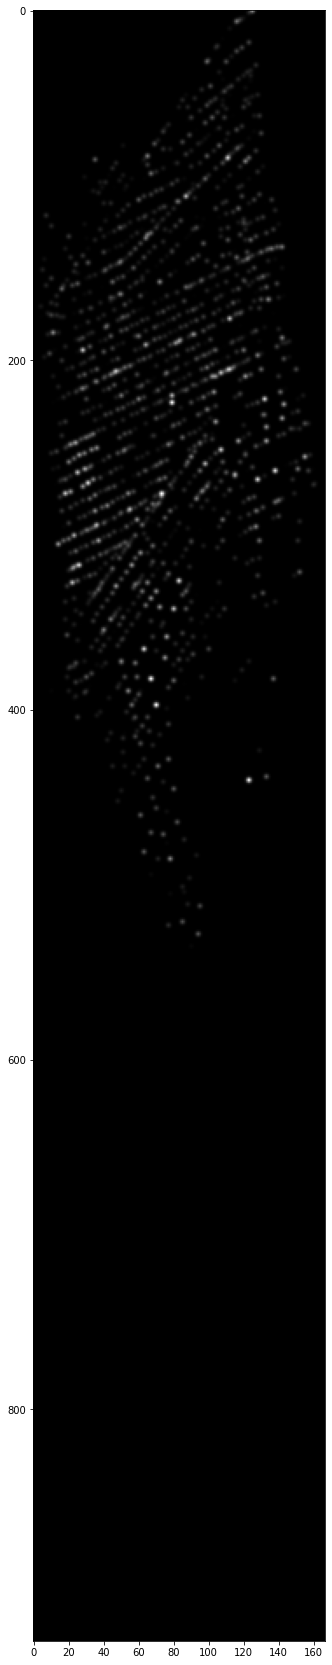

In [97]:
plt.figure(figsize=(30, 30))

plt.imshow(img3D_conv[:,:,4], cmap='gray');

### 6H Step

#### Computation

In [98]:
def from_coord_to_matrix(df, lat_meters, lon_meters):
    """
    outputs the 3D matrix of all coordinates for a given bucket height and width in meters
    """
    df = df.copy()
    #add 'time_index' column to df
    ind = {time: index for index, time in enumerate(np.sort(df['six_hour_date'].unique()))}
    df['time_index'] = df['six_hour_date'].map(ind)
    
    #initiate matrix
    #40.49611539518921, 40.91553277600008, -74.25559136315213,-73.70000906387347) : NYC boundaries
    #([40.56952999448672, 40.73912795313436],[-74.04189660705046, -73.83355923946421]) : brooklyn boundaries
    #[40.6218192717505, 40.6951504231971],[-73.90404639808888, -73.83559344190869]) :precinct 75 boundaries
    
    # Where do you start
    grid_offset = np.array([-40.691192349, -73.904645897, 0])
    #from meters to lat/lon step
    lat_spacing, lon_spacing = from_meters_to_coords(lat_meters, lon_meters )
    grid_spacing = np.array([lat_spacing , lon_spacing,1]) # What's the space you consider (euclidian here)
     
    
    #get points coordinates
    coords = np.array([( -lat, lon,t_ind) for lat, lon,t_ind \
                   in zip(df['latitude'],df['longitude'],df['time_index'])])
    
    
    # Convert point to index
    indexes = np.round((coords - grid_offset)/grid_spacing).astype('int')
    X = indexes[:,0]
    Y = indexes[:,1]
    Z = indexes[:,2]
    
    #virgin matrix
    a = np.zeros((X.max()+1, Y.max()+1, Z.max()+1))
   
    
    a[X, Y, Z]=1
    
    return a, a.shape[1], a.shape[2]

In [99]:
img, lat_size, lon_size = from_coord_to_matrix(sample, 10, 25)

#### Without Gaussian

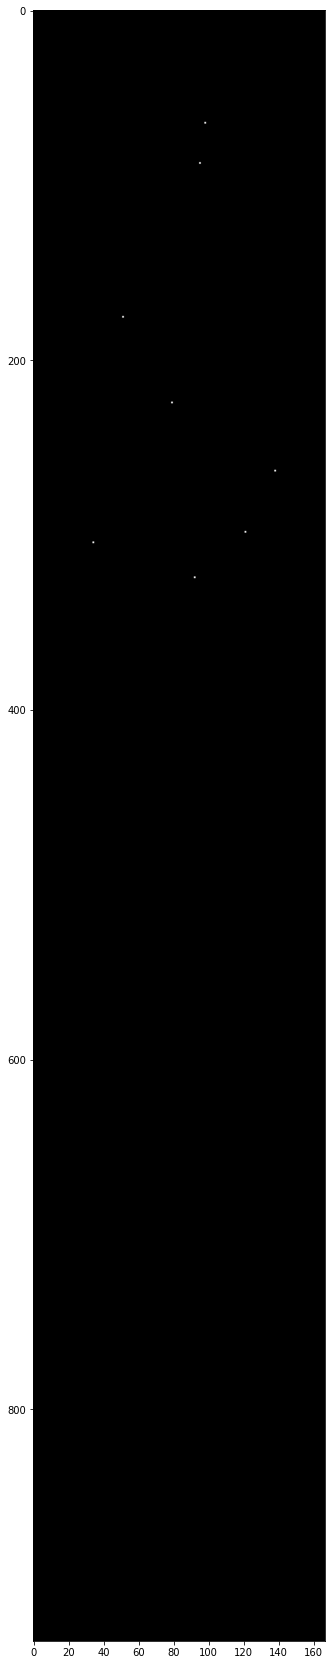

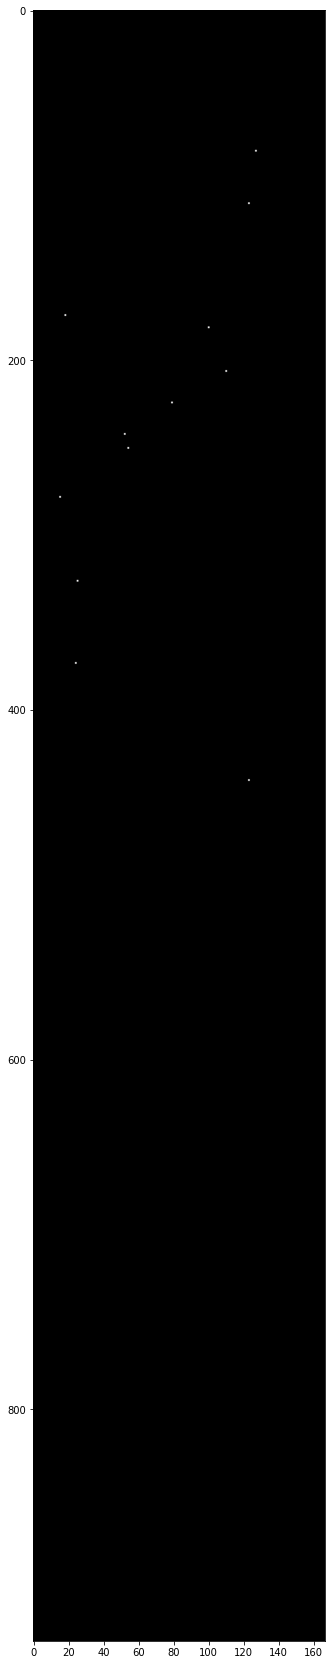

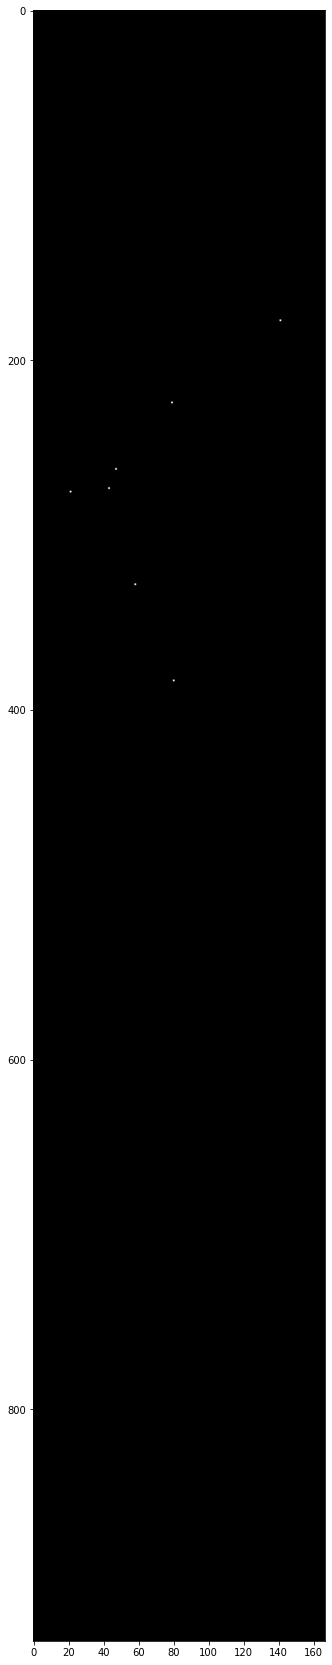

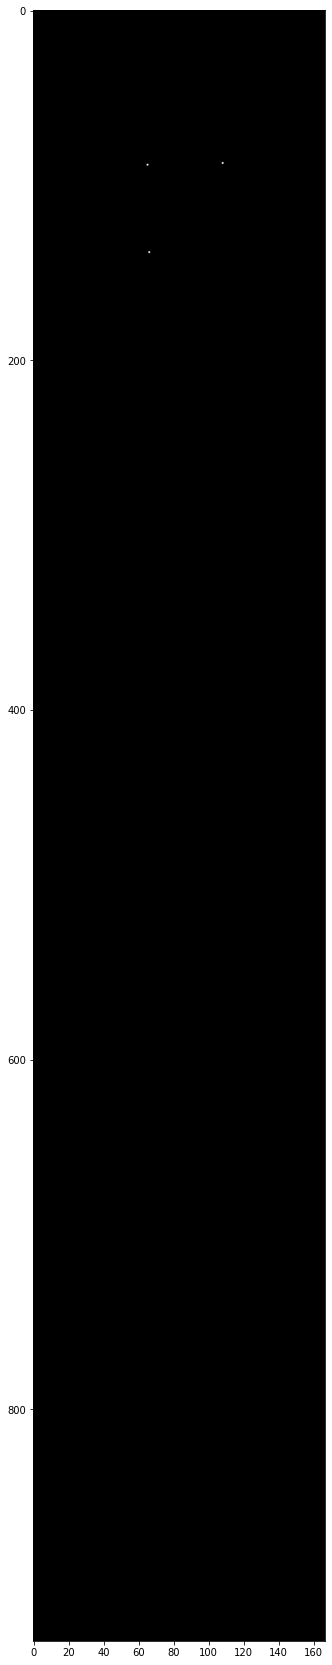

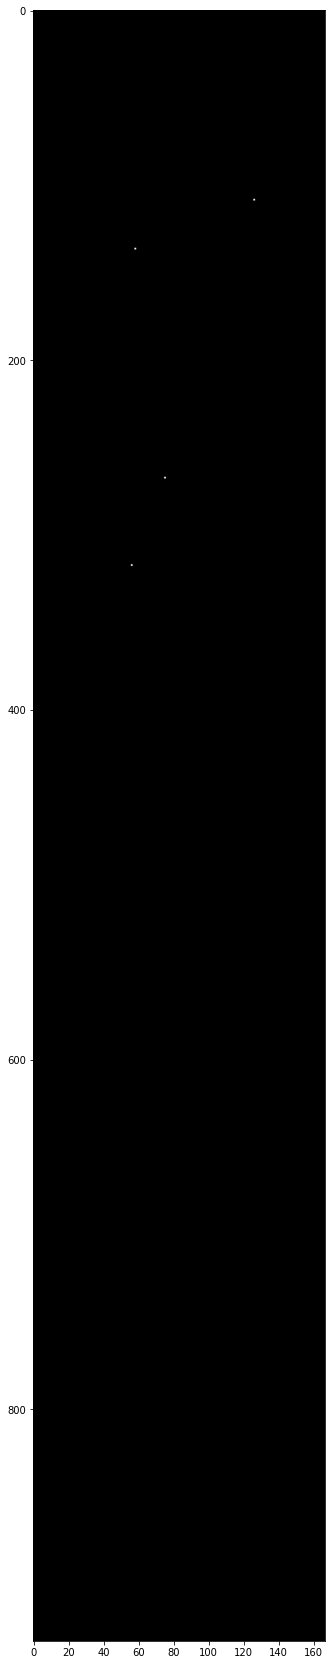

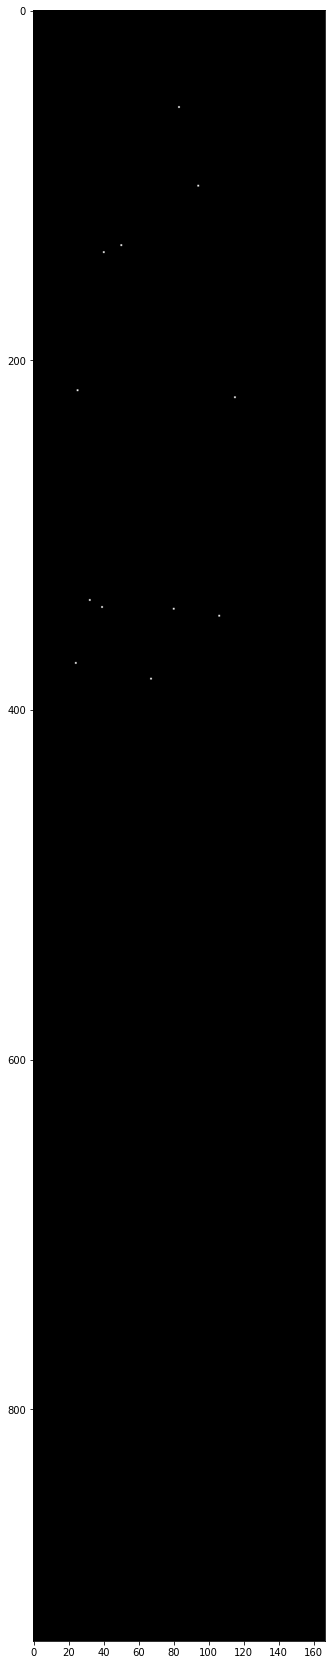

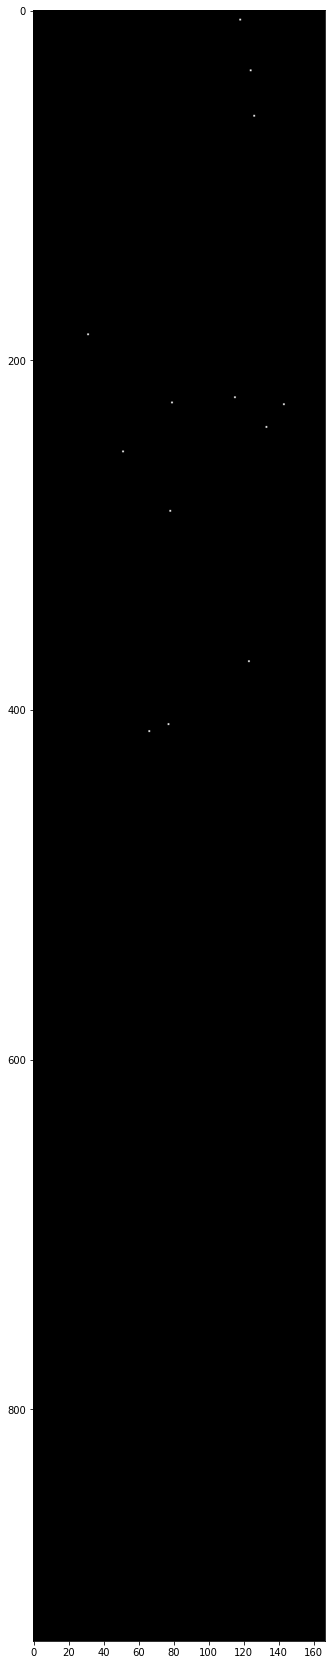

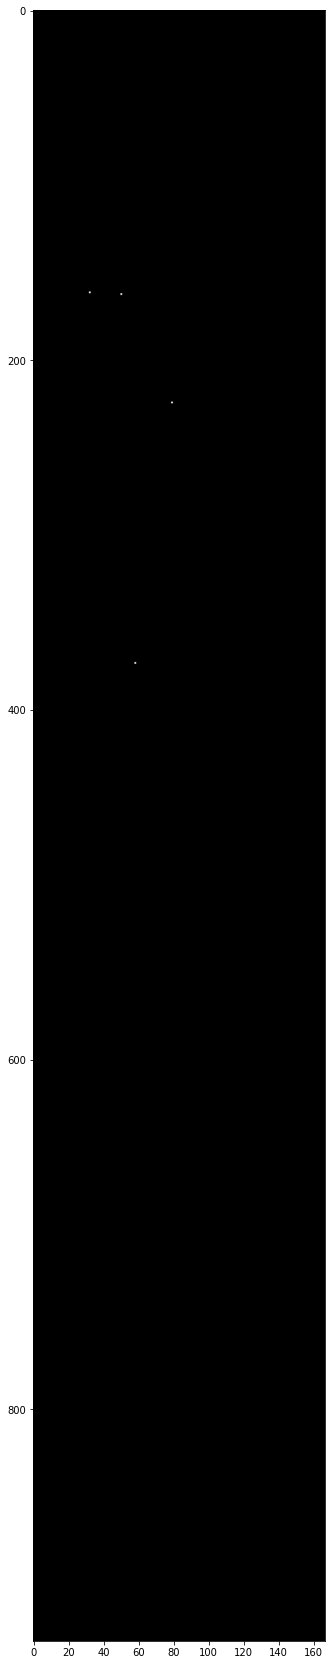

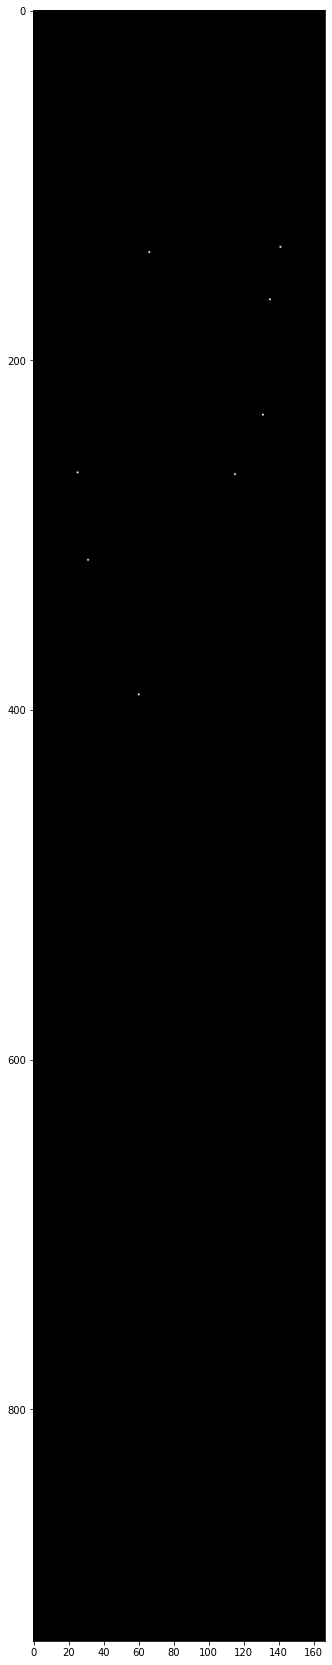

In [100]:
max_lum = img.max()

for i in range(9):
    plt.figure(figsize = (30, 30))
    plt.imshow(img[:, :, i + 1], cmap = 'gray', vmin = 0, vmax = max_lum)
    plt.show()

#### With Gaussian

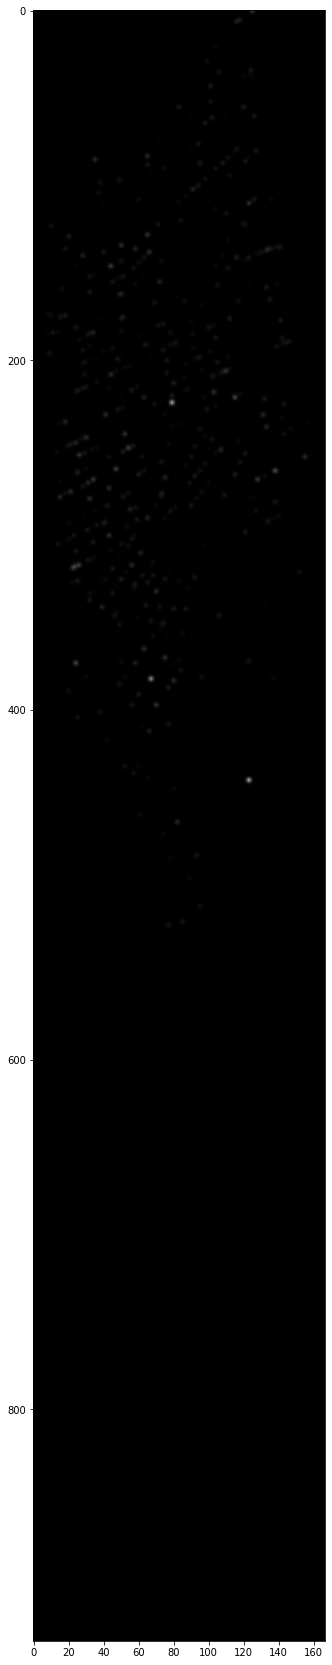

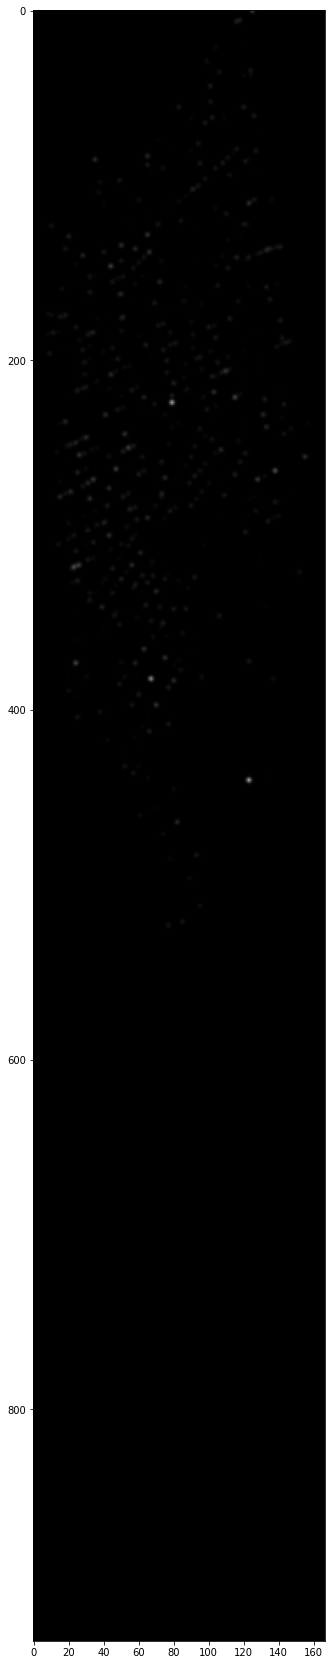

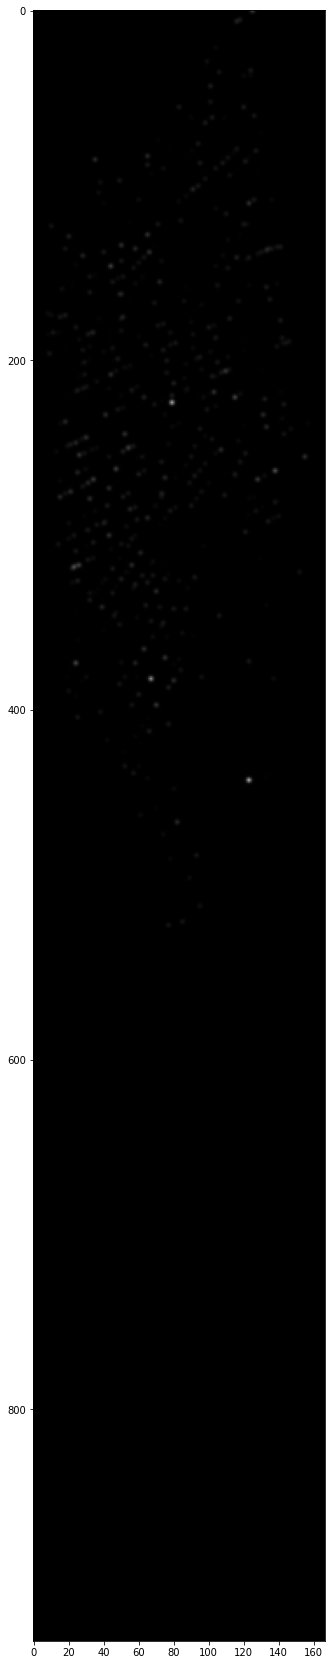

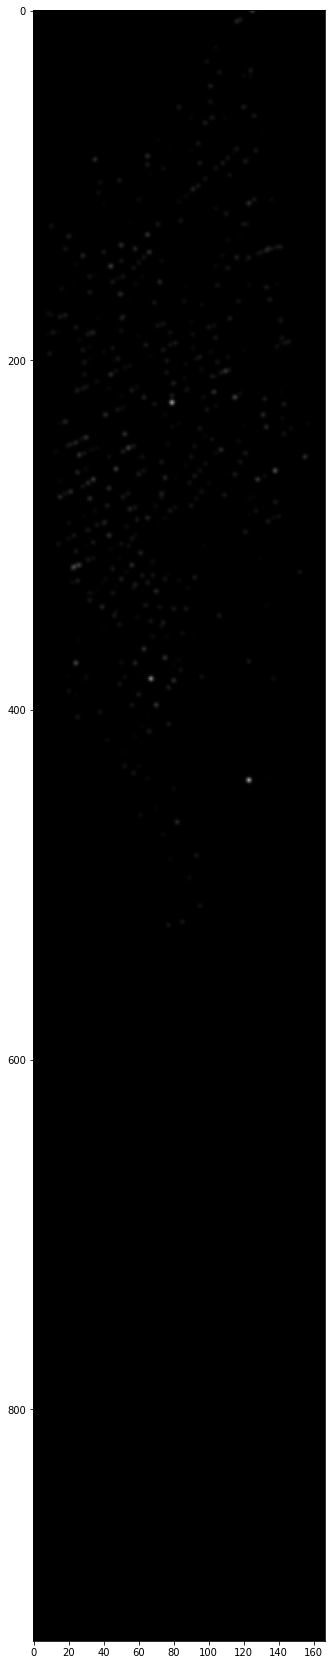

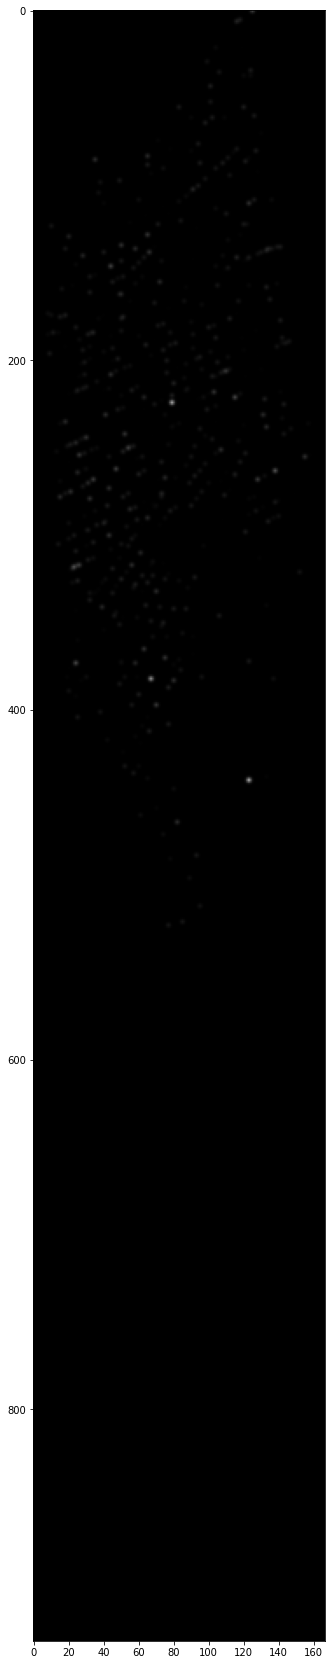

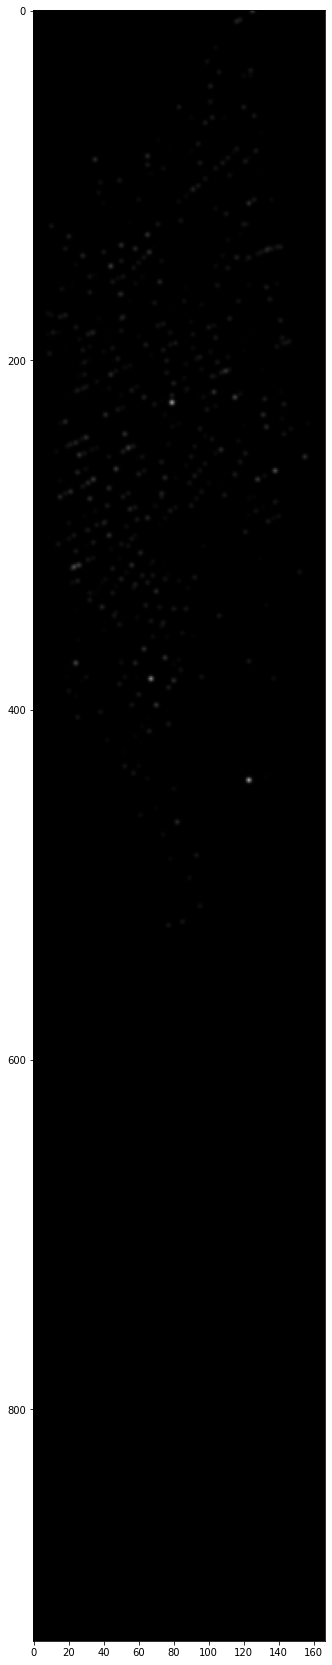

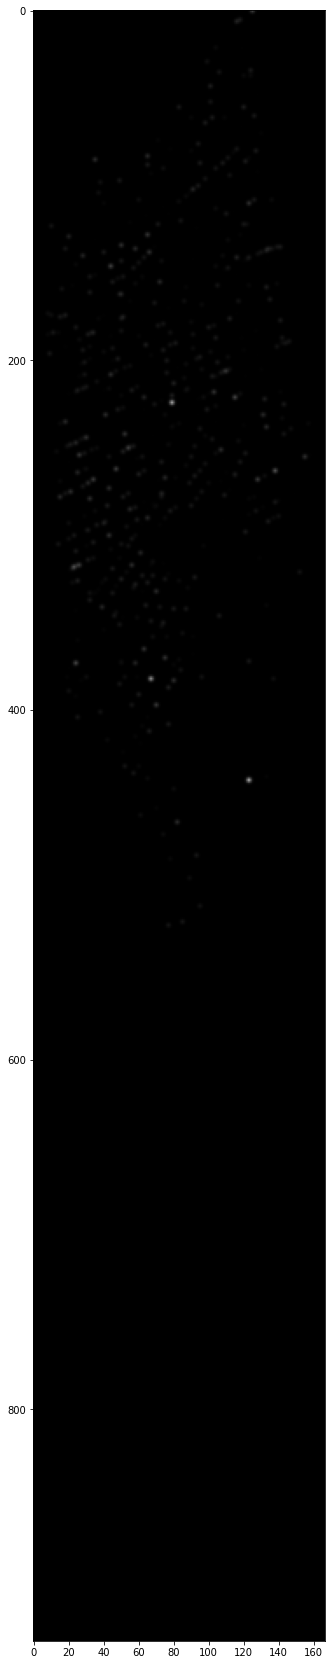

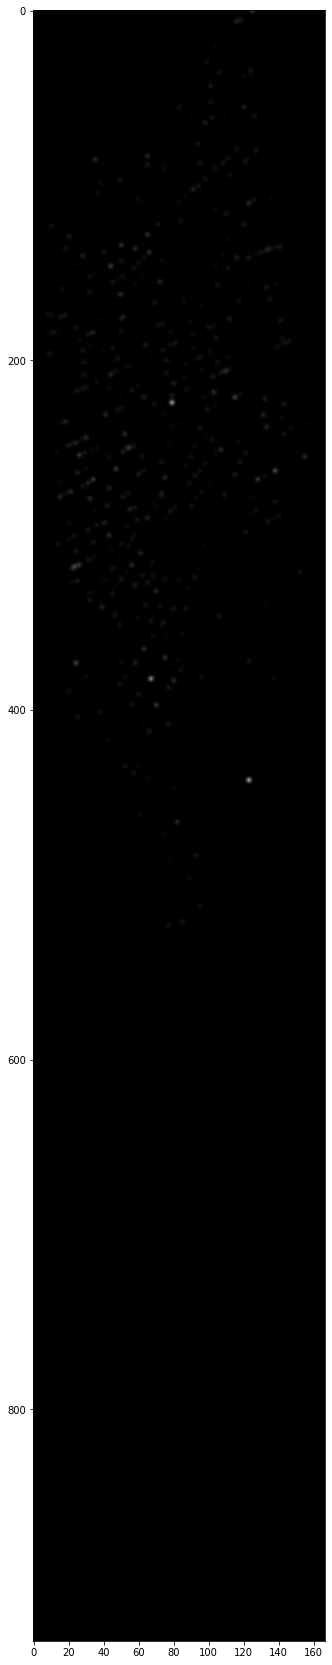

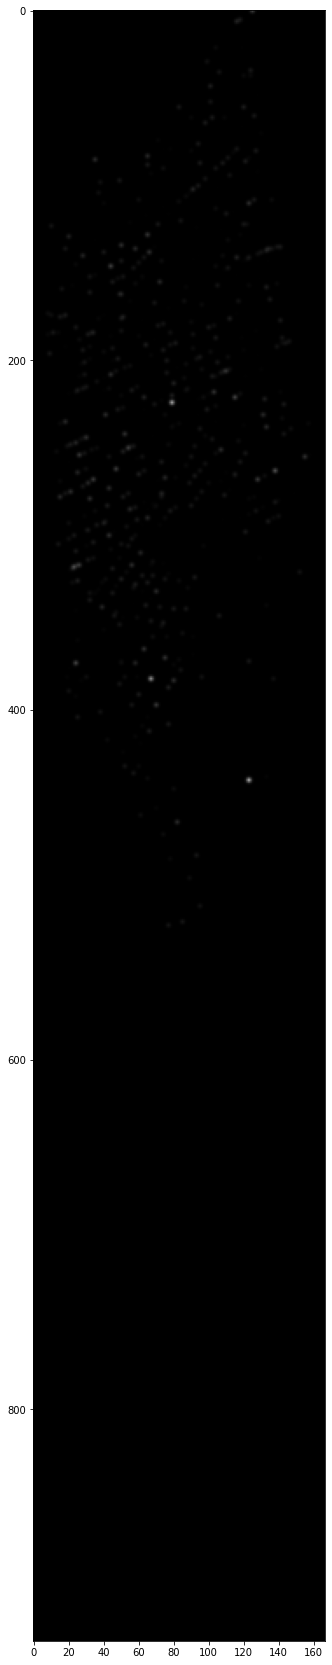

In [102]:
img3D_conv = gaussian_filter(img, sigma=(1, 1, 28))

max_lum = img3D_conv.max()

for i in range(9):
    plt.figure(figsize=(30, 30))
    plt.imshow(img3D_conv[:, :, i + 1], cmap = 'gray', vmin = 0, vmax = max_lum)
    plt.show()